In [1002]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA

In [1003]:
df = pd.read_csv("../data/Diabetes.csv")

# Renaming the columns
column_renames = {
    "Number of times pregnant": "Number_Pregnant",
    "Plasma glucose concentration a 2 hours in an oral glucose tolerance test": "Glucose_Concentration",
    "Diastolic blood pressure (mm Hg)": "Blood_Pressure",
    "Triceps skin fold thickness (mm)": "Skin_Thickness",
    "2-Hour serum insulin (mu U/ml)": "Serum_insulin",
    "Body mass index (weight in kg/(height in m)^2)": "BMI",
    "Diabetes pedigree function": "Diabetes_pedigree_function",
    "Age (years)": "Age",
    "Class variable (0 or 1)": "Diabetes",
}

df.rename(columns=column_renames, inplace=True)
df["Diabetes"] = df["Diabetes"].replace(0, -1)

# Remove these columns since too many missing entries to perform KPCA on 
df = df.drop(["Serum_insulin"], axis=1)
df = df.drop(["Skin_Thickness"], axis=1)

train = df.sample(frac=0.8)
test = df.drop(train.index)

train_data = train.drop(["Diabetes"], axis=1).to_numpy()
train_outcome = test["Diabetes"].to_numpy()

test_data = test.drop(["Diabetes"], axis=1).to_numpy()
test_outcome = test["Diabetes"].to_numpy()

# Normilizing data
train_data = (train_data - np.mean(train_data, axis=0)) / np.std(train_data, axis=0)
test_data = (test_data - np.mean(test_data, axis=0)) / np.std(test_data, axis=0)

print(f"Mean of each column: {np.mean(train_data, axis=0)}\n")
print(f"Standard deviation of each column: {np.std(train_data, axis=0)}")

Mean of each column: [ 1.01258126e-17 -2.11195520e-16  2.53145315e-16 -1.46101010e-16
  1.56226823e-16  2.14088609e-16]

Standard deviation of each column: [1. 1. 1. 1. 1. 1.]


In [1004]:
def gaussian_kernel(a, b, gamma):
    return np.exp(-gamma * (np.linalg.norm(a - b) ** 2))

## Calculating the components using KPCA

Since the mean of $\phi(X)$ needs to be 0 we need to apply the folling formula to center our kernel matrix

$\bar{K}(x_i, x_j)=K(x_i, x_j) - \frac{1}{d}\displaystyle\sum_{k=1} ^{d} K(x_i, x_k) - \frac{1}{d}\displaystyle\sum_{k=1} ^{d} K(x_i, x_k) - \frac{1}{d^2}\displaystyle\sum_{l,k=1} ^{d} K(x_l, x_k)$

In [1005]:
def calculate_kernelPCA(data, n_components=None, gamma=None):
    threshold = 1e-10

    if gamma is None:
        gamma = 1 / data.shape[1]

    # Calculate the kernal metrix using the provided kernel function
    kernel_matrix = np.array([[gaussian_kernel(d1, d2, gamma) for d1 in data] for d2 in data])

    # Centering the kernel matrix
    kernel_matrix = kernel_matrix - np.mean(kernel_matrix, axis=1)[:, np.newaxis] - np.mean(kernel_matrix, axis=0) - np.mean(kernel_matrix)

    # Calculate the eigenvalues and eigenvectors 
    eigenvalues, eigenvectors = np.linalg.eig(kernel_matrix)

    # Sort the eigenvalues and eigenvectors based on the values of the eigenvalue
    sorted_indices = np.argsort(eigenvalues)[::-1]
    lambdas = eigenvalues[sorted_indices]
    alphas = eigenvectors[:, sorted_indices]

    # Remove eigenvalues and eigenvectors where the eigenvalue is less than the threshold
    lambdas = lambdas[lambdas > threshold]
    alphas = alphas[:, :lambdas.shape[0]]
    
    if n_components is None:
        n_components = lambdas.shape[0]
    else:
        n_components = min(lambdas.shape[0], n_components)

    return alphas.real[:, :n_components], lambdas.real[:n_components]

In [1006]:
alphas, lambdas = calculate_kernelPCA(train_data, n_components=2)
print(alphas.shape)

(614, 2)


In [1007]:
def project_data(data_point, data, alphas, gamma=None):
    if gamma is None:
        gamma = 1 / data.shape[1]
    
    return np.array([np.sum([
        alpha[i] * gaussian_kernel(data_point, data[i], gamma) for i in range(data.shape[0])
    ]) for alpha in alphas.T])

In [1008]:
projected_data_points = np.array([
    project_data(data_point, train_data, alphas) for data_point in test_data
])

print(projected_data_points)

[[ 2.14393337e+00 -5.13549785e-01]
 [-1.17259033e+00 -7.59598132e-01]
 [ 5.36149637e+00  1.32703323e+00]
 [ 4.55714720e+00  3.70610019e+00]
 [-1.94527682e-01 -4.58287266e-01]
 [ 3.49967107e-02  7.80344869e-02]
 [ 3.29295986e+00  6.69129399e-01]
 [ 8.57468238e-01  2.57013036e+00]
 [ 4.50383008e+00  2.20117658e+00]
 [ 2.34363004e-02  7.26996064e-02]
 [-2.18838202e+00  2.25050265e+00]
 [-2.16902841e+00  1.42077043e+00]
 [ 6.35484608e+00  1.77661529e+00]
 [-7.61955373e-01  8.70138782e-01]
 [ 4.32693582e+00  2.19554984e+00]
 [ 3.77245599e+00 -5.59943121e-02]
 [ 6.26913788e+00  2.11305293e+00]
 [ 1.66790094e+00  7.09369385e-01]
 [-1.06282628e+00  2.31119271e-01]
 [-2.29652213e+00  4.55895670e-01]
 [-3.87820955e-01 -3.18645885e-02]
 [ 6.36283360e+00  5.05538709e-01]
 [-1.44240013e+00  3.26086693e+00]
 [ 2.87302401e+00  2.83734303e+00]
 [ 1.68107868e+00 -3.46736121e+00]
 [ 6.42700759e+00  1.87697386e+00]
 [ 3.79144386e-01  7.34698552e-02]
 [-7.00152302e-01  2.22969854e+00]
 [ 6.87551299e+00  1

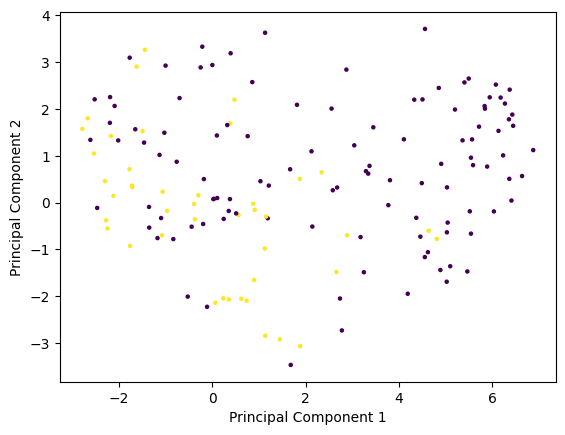

In [1009]:
plt.xlabel(f"Principal Component 1")
plt.ylabel(f"Principal Component 2")
plt.scatter(projected_data_points[:, 0], projected_data_points[:, 1], c=test_outcome, s=5)
plt.show()